# LSTM
A LSTM model for predicting product fractions for a specific product for a customer.

In [528]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error
from math import sqrt

## Import dataset
Import the dataset and select a customer and a product to run the model on.

In [529]:
df = pd.read_csv("datasets/Hydro_NTNU_prod_mix_dataset_preprocessed.csv", delimiter=";")
df = df[(df['CUSTOMER_ID'] == 3490871) & (df['AREA'] == 'BE UIE') & (df['PRODUCT_TYPE_ID'] == 10) & (df['PRODUCT_CATEGORY'] == 'OUT') & (df['PRODUCT_ID'] == 8482)]

## Format dataset
Remove useless attributes.

In [530]:
df = df.loc[:, ['PRODUCT_FRACTION', 'MONTH', 'YEAR']]
df

PRODUCT_FRACTION  MONTH  YEAR
9310           0.760000      1  2021
9312           0.666667      1  2020
9316           0.111111      1  2019
9320           0.625000      1  2018
9323           0.375000      1  2017
...                 ...    ...   ...
9481           0.500000     12  2020
9483           0.500000     12  2018
9485           0.500000     12  2017
9489           0.166667     12  2015
93042          0.225000      6  2015

[70 rows x 3 columns]

Add missing months (PRODUCT_FRACTION = 0).

In [531]:
for year in range(2015, 2022):
    for month in range (1, 13):
        if ((not ((df['YEAR'] == year) & (df['MONTH'] == month)).any())):
            if (not (year == 2021 and month > 7)):
                df = df.append({'PRODUCT_FRACTION': 0, 'MONTH': month, 'YEAR': year}, ignore_index=True)

df = df.sort_values(['YEAR', 'MONTH'], ascending=[True, True])
df

PRODUCT_FRACTION  MONTH  YEAR
70          0.000000      1  2015
11          0.272727      2  2015
18          0.200000      3  2015
25          0.062500      4  2015
31          0.125000      5  2015
..               ...    ...   ...
12          0.750000      3  2021
19          1.000000      4  2021
26          1.000000      5  2021
32          1.000000      6  2021
37          1.000000      7  2021

[79 rows x 3 columns]

Combine MONTH and YEAR attributes to a DATE attribute.

In [532]:
df = df.reset_index(drop=True)
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1))
df = df.drop(['YEAR', 'MONTH'], axis=1)
df = df[['DATE', 'PRODUCT_FRACTION']]
df['DATE'] = df['DATE'].dt.strftime('%Y-%m-%d')
df

DATE  PRODUCT_FRACTION
0   2015-01-01          0.000000
1   2015-02-01          0.272727
2   2015-03-01          0.200000
3   2015-04-01          0.062500
4   2015-05-01          0.125000
..         ...               ...
74  2021-03-01          0.750000
75  2021-04-01          1.000000
76  2021-05-01          1.000000
77  2021-06-01          1.000000
78  2021-07-01          1.000000

[79 rows x 2 columns]

## Plot values
Plot the product fraction per month.

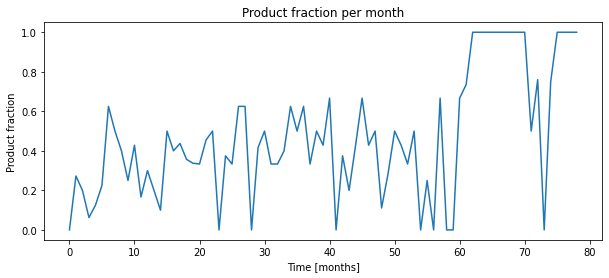

In [533]:
plt.figure(figsize=(10, 4))
plt.plot(df['PRODUCT_FRACTION'])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.ylabel('Product fraction')
plt.xlabel('Time [months]')
plt.title("Product fraction per month")
plt.show()

## Train/test split
Split into a training and testing set. 55/24 split.

In [534]:
train = df.iloc[:55]['PRODUCT_FRACTION'].copy()
test = df.iloc[55:].copy() # Test on the last 24 months

# Format training set for TimeseriesGenerator
train = np.array([[train[i]] for i in range(len(train.to_numpy()))])

Plot train/test split.

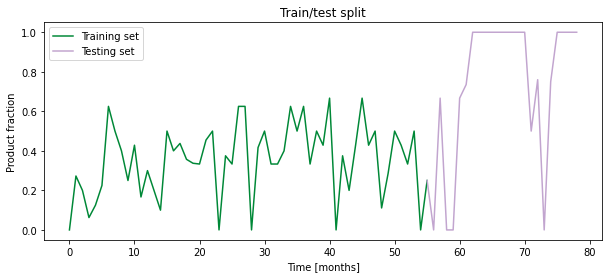

In [535]:
plt.figure(figsize=(10, 4))
plt.plot(df.iloc[:56]['PRODUCT_FRACTION'].copy(), label="Training set", color="#008837")
plt.plot(test['PRODUCT_FRACTION'], label="Testing set", color="#c2a5cf")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.ylabel('Product fraction')
plt.xlabel('Time [months]')
plt.title("Train/test split")
plt.legend()
plt.show()

Set up a time series generator for using the last 12 values (both original and predicted values) to predict the next value.

In [536]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=1)

## Modeling
Make a LSTM model.

In [537]:
model = Sequential()
model.add(LSTM(64, input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Train the model.

In [538]:
model.fit(generator, epochs=50)

Epoch 1/50
43/43 [==============================] - 2s 4ms/step - loss: 0.0487
Epoch 2/50
43/43 [==============================] - 0s 4ms/step - loss: 0.0347
Epoch 3/50
43/43 [==============================] - 0s 5ms/step - loss: 0.0394
Epoch 4/50
43/43 [==============================] - 0s 4ms/step - loss: 0.0368
Epoch 5/50
43/43 [==============================] - 0s 4ms/step - loss: 0.0385
Epoch 6/50
43/43 [==============================] - 0s 5ms/step - loss: 0.0350
Epoch 7/50
43/43 [==============================] - 0s 4ms/step - loss: 0.0396
Epoch 8/50
43/43 [==============================] - 0s 4ms/step - loss: 0.0357
Epoch 9/50
43/43 [==============================] - 0s 4ms/step - loss: 0.0349
Epoch 10/50
43/43 [==============================] - 0s 4ms/step - loss: 0.0335
Epoch 11/50
43/43 [==============================] - 0s 4ms/step - loss: 0.0325
Epoch 12/50
43/43 [==============================] - 0s 5ms/step - loss: 0.0362
Epoch 13/50
43/43 [==============================

Plot the loss per epoch.

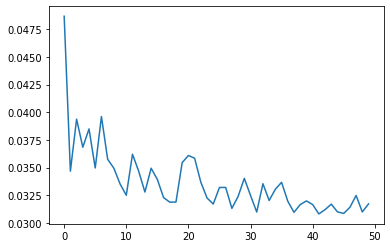

In [539]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Prediction

Predict values in the testing set.

In [540]:
test_predictions = []

first_eval_batch = train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred[0]) 
    
    # use the prediction to update the batch and remove the first value
    # (so the current batch is updated with the predicted value in order to predict the next value)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

Add the predicted values to the testing set.

In [541]:
test['PREDICTED_PRODUCT_FRACTION'] = test_predictions
test

DATE  PRODUCT_FRACTION  PREDICTED_PRODUCT_FRACTION
55  2019-08-01          0.250000                    0.450481
56  2019-09-01          0.000000                    0.437411
57  2019-10-01          0.666667                    0.409441
58  2019-11-01          0.000000                    0.378828
59  2019-12-01          0.000000                    0.373461
60  2020-01-01          0.666667                    0.370549
61  2020-02-01          0.735294                    0.386114
62  2020-03-01          1.000000                    0.387901
63  2020-04-01          1.000000                    0.381139
64  2020-05-01          1.000000                    0.382150
65  2020-06-01          1.000000                    0.388107
66  2020-07-01          1.000000                    0.386406
67  2020-08-01          1.000000                    0.404611
68  2020-09-01          1.000000                    0.396267
69  2020-10-01          1.000000                    0.392231
70  2020-11-01          1.000000                    0.391819
71  2020-12-01          0.500000                    0.393609
72  2021-01-01          0.760000                    0.395446
73  2021-02-01          0.000000                    0.396993
74  2021-03-01          0.750000                    0.397556
75  2021-04-01          1.000000                    0.398086
76  2021-05-01          1.000000                    0.398870
77  2021-06-01          1.000000                    0.399428
78  2021-07-01          1.000000                    0.399650

Plot the predicted values along with the actual values.

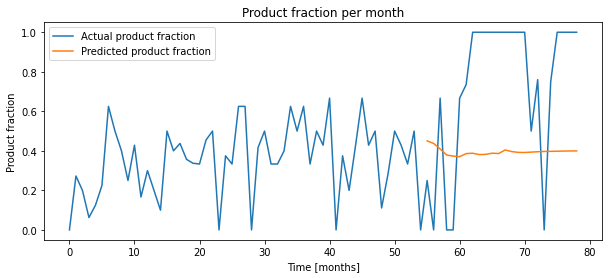

In [542]:
plt.figure(figsize=(10, 4))
plt.plot(df['PRODUCT_FRACTION'], label="Actual product fraction")
plt.plot(test['PREDICTED_PRODUCT_FRACTION'], label="Predicted product fraction")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.ylabel('Product fraction')
plt.xlabel('Time [months]')
plt.title("Product fraction per month")
plt.legend()
plt.show()

Calculate the root mean squared error.

In [543]:
mse = mean_squared_error(test['PRODUCT_FRACTION'],test['PREDICTED_PRODUCT_FRACTION'])
print(mse)

0.2504014107272878
